# 라이브러리 불러오기

In [1]:
import os
from pathlib import Path

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from geopy.distance import geodesic
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans

# 시각화 함수

In [2]:
def rangeplot(df, x, y, color=None, alpha=0.1, marker="<"):

    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

# 랜덤 시드 설정

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
# 데이터 경로 설정
data_path = Path("../data")

# 데이터 파일 불러오기
train_data = pd.read_csv(data_path / 'train.csv')
test_data = pd.read_csv(data_path / 'test.csv')
train_dist = pd.read_csv(data_path / 'train_dist.csv')
test_dist = pd.read_csv(data_path / 'test_dist_origin.csv')
sample_submission = pd.read_csv(data_path / 'sample_submission.csv')
school_data = pd.read_csv(data_path / 'schoolinfo.csv')
park_data = pd.read_csv(data_path / 'parkInfo.csv')
subway_data = pd.read_csv(data_path / 'subwayInfo.csv')
interest_data = pd.read_csv(data_path / 'interestRate.csv')

# 전처리
- 중복 제거
- 거래 날짜순 정렬

In [5]:
# 가까운 거리 구할 때 index를 각각의 아이디로 사용
park_data['id'] = park_data.index
subway_data['id'] = subway_data.index
school_data['id'] = school_data.index

In [6]:
# duplicated data 제거
dup_df = train_dist[train_dist.drop(columns="index").duplicated()]
train_dist = train_dist.drop(index=dup_df.index)

train_dist.shape

(1717611, 18)

In [7]:
# 'contract_year_month'와 'contract_day'를 결합하여 새로운 열 'contract_date' 생성
train_dist['contract_date'] = pd.to_datetime(train_dist['contract_year_month'].astype(str) + train_dist['contract_day'].astype(str), format='%Y%m%d')
test_dist['contract_date'] = pd.to_datetime(test_dist['contract_year_month'].astype(str) + test_dist['contract_day'].astype(str), format='%Y%m%d')


In [8]:
train_dist = train_dist.sort_values('contract_date').reset_index(drop=True)

# 평당 가격

In [9]:
train_dist['deposit_per_area']= train_dist['deposit'] / train_dist['area_m2']

# 위도 경도 클러스터링 

In [10]:
def perform_clustering(train_dist, test_dist, n_clusters=100):
    # 위도와 경도 데이터 추출 (Train)
    X_train = train_dist[['latitude', 'longitude']]

    # K-means 클러스터링 (Train 데이터에 대해 학습)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train_dist['cluster'] = kmeans.fit_predict(X_train)

    # 위도와 경도 데이터 추출 (Test)
    X_test = test_dist[['latitude', 'longitude']]

    # Test 데이터에 대해 클러스터 예측
    test_dist['cluster'] = kmeans.predict(X_test)

    return train_dist, test_dist

In [11]:
train_dist, test_dist = perform_clustering(train_dist, test_dist, n_clusters=100)

# 평균 가격

In [12]:
building_counts = train_dist.groupby(['latitude', 'longitude']).size().reset_index(name='count')
building_counts

,latitude,longitude,count
0,36.92,126.91,15
1,36.96,127.05,72
2,36.96,127.05,3
3,36.96,127.06,95
4,36.96,127.05,5
...,...,...,...
18486,38.10,127.08,4
18487,38.10,127.08,29
18488,38.10,127.08,77
18489,38.11,127.08,19


In [13]:
building_counts_test = test_dist.groupby(['latitude', 'longitude']).size().reset_index(name='count')
building_counts_test

,latitude,longitude,count
0,36.96,127.05,3
1,36.96,127.06,2
2,36.96,127.05,2
3,36.96,126.86,5
4,36.96,127.06,4
...,...,...,...
11880,38.03,127.07,2
11881,38.04,127.07,4
11882,38.10,127.08,2
11883,38.10,127.08,10


In [14]:
# 현재 기준 연도 설정 (예를 들어, 2023 12 월 31일을 기준으로 최근 1년간 데이터를 계산한다고 가정)
current_date = pd.to_datetime('2023-12-31')

one_year_ago = current_date - pd.DateOffset(years=1)
df_last_year = train_dist[train_dist['contract_date'] >= one_year_ago]

building_price_avg = df_last_year.groupby(['latitude', 'longitude'])['deposit_per_area'].mean().reset_index()
building_price_avg = building_price_avg.rename(columns={'deposit_per_area': 'avg_deposit'})


#print(building_price_avg)

In [15]:
building_price_avg.describe()

,latitude,longitude,avg_deposit
count,14772.00,14772.00,14772.00
mean,37.49,126.96,460.93
std,0.15,0.17,247.69
min,36.92,126.48,27.95
25%,37.42,126.84,286.98
50%,37.51,126.97,409.43
75%,37.57,127.07,573.47
max,38.11,127.66,2968.26


In [16]:
# 최근 1년간 거래가 없는 건물 - 마지막 거래 가져오기
df_last_transaction = train_dist.groupby(['latitude', 'longitude']).apply(lambda x: x.loc[x['contract_date'].idxmax()])
df_last_transaction = df_last_transaction[['latitude', 'longitude', 'deposit_per_area']].reset_index(drop=True)
df_last_transaction = df_last_transaction.rename(columns={'deposit_per_area': 'last_deposit'})

/var/folders/ys/k4wnzt2n67z3y95b6k2f35qm0000gn/T/ipykernel_31120/1178878971.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_last_transaction = train_dist.groupby(['latitude', 'longitude']).apply(lambda x: x.loc[x['contract_date'].idxmax()])


In [17]:
result = pd.merge(df_last_transaction, building_price_avg, on=['latitude', 'longitude'], how='left')
result['final_price'] = result['avg_deposit'].combine_first(result['last_deposit'])

#rint(result[['latitude', 'longitude', 'final_price']])

In [18]:
train_dist = pd.merge(train_dist, result[['latitude', 'longitude', 'final_price']], on=['latitude', 'longitude'], how='left')
test_dist = pd.merge(test_dist, result[['latitude', 'longitude', 'final_price']], on=['latitude', 'longitude'], how='left')

In [19]:
def fill_missing_final_price_in_test(train_dist,test_dist):
    """
    Test 데이터에서 final_price가 없는 경우 같은 클러스터에 속한 건물들의 평균 final_price로 대체하는 함수.

    Parameters:
    - test_dist: Test 데이터프레임

    Returns:
    - test_dist: final_price가 같은 클러스터의 평균값으로 대체된 데이터프레임
    """
    # 먼저 test_dist에서 클러스터별 final_price의 평균값 계산
    cluster_avg_price_test = train_dist.groupby('cluster')['final_price'].mean().reset_index()

    # Test 데이터셋에 final_price가 없는 건물들을 같은 클러스터의 평균값으로 대체
    test_dist = pd.merge(test_dist, cluster_avg_price_test, on='cluster', how='left', suffixes=('', '_cluster_avg'))

    # final_price가 없는 경우, 해당 클러스터의 평균값으로 대체
    test_dist['final_price'] = test_dist['final_price'].fillna(test_dist['final_price_cluster_avg'])

    # 불필요한 'final_price_cluster_avg' 열 제거
    test_dist = test_dist.drop(columns=['final_price_cluster_avg'])

    return test_dist

In [20]:
test_dist = fill_missing_final_price_in_test(train_dist,test_dist)
test_dist.isna().sum()

index                      0
area_m2                    0
contract_year_month        0
contract_day               0
contract_type              0
floor                      0
built_year                 0
latitude                   0
longitude                  0
age                        0
nearest_subway_distance    0
nearest_subway_id          0
nearest_school_distance    0
nearest_school_id          0
nearest_park_distance      0
nearest_park_id            0
interest_rate              0
contract_date              0
cluster                    0
final_price                0
dtype: int64

In [21]:
# cluster 컬럼에 대해 원핫 인코딩 적용
train_dist = pd.get_dummies(train_dist, columns=['cluster'], prefix='cluster')
test_dist =  pd.get_dummies(test_dist, columns=['cluster'], prefix='cluster')

In [22]:
train_dist[train_dist.select_dtypes(include=['bool']).columns] = train_dist.select_dtypes(include=['bool']).astype(int)
test_dist[test_dist.select_dtypes(include=['bool']).columns] = test_dist.select_dtypes(include=['bool']).astype(int)

# 대회에 필요한 데이터만 활용하기

In [23]:
columns_needed = ['area_m2', 'age','contract_year_month' ,'contract_type', 'floor', 'deposit','deposit_per_area','nearest_subway_distance','nearest_school_distance','interest_rate',
 'nearest_school_id','nearest_subway_id','final_price']

#cluster_0부터 cluster_99까지 추가
cluster_columns = [f'cluster_{i}' for i in range(0, 100)]
columns_needed.extend(cluster_columns)

columns_needed_test = ['area_m2', 'age','contract_year_month' ,'contract_type', 'floor','nearest_subway_distance','nearest_school_distance','interest_rate',
 'nearest_school_id','nearest_subway_id','final_price']

columns_needed_test.extend(cluster_columns)
train_data = train_dist[columns_needed]
test_data = test_dist[columns_needed_test]

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [24]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [25]:
X_train = train_data.drop(columns=['deposit','deposit_per_area'])
y_train = train_data['deposit_per_area']
X_holdout = holdout_data.drop(columns=['deposit','deposit_per_area'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [26]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 108
[LightGBM] [Info] Start training from score 412.223690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

# Holdout 데이터셋에 대한 성능 확인

In [27]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_pred_origin = lgb_holdout_pred*holdout_data['area_m2']
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred_origin)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 4444.37


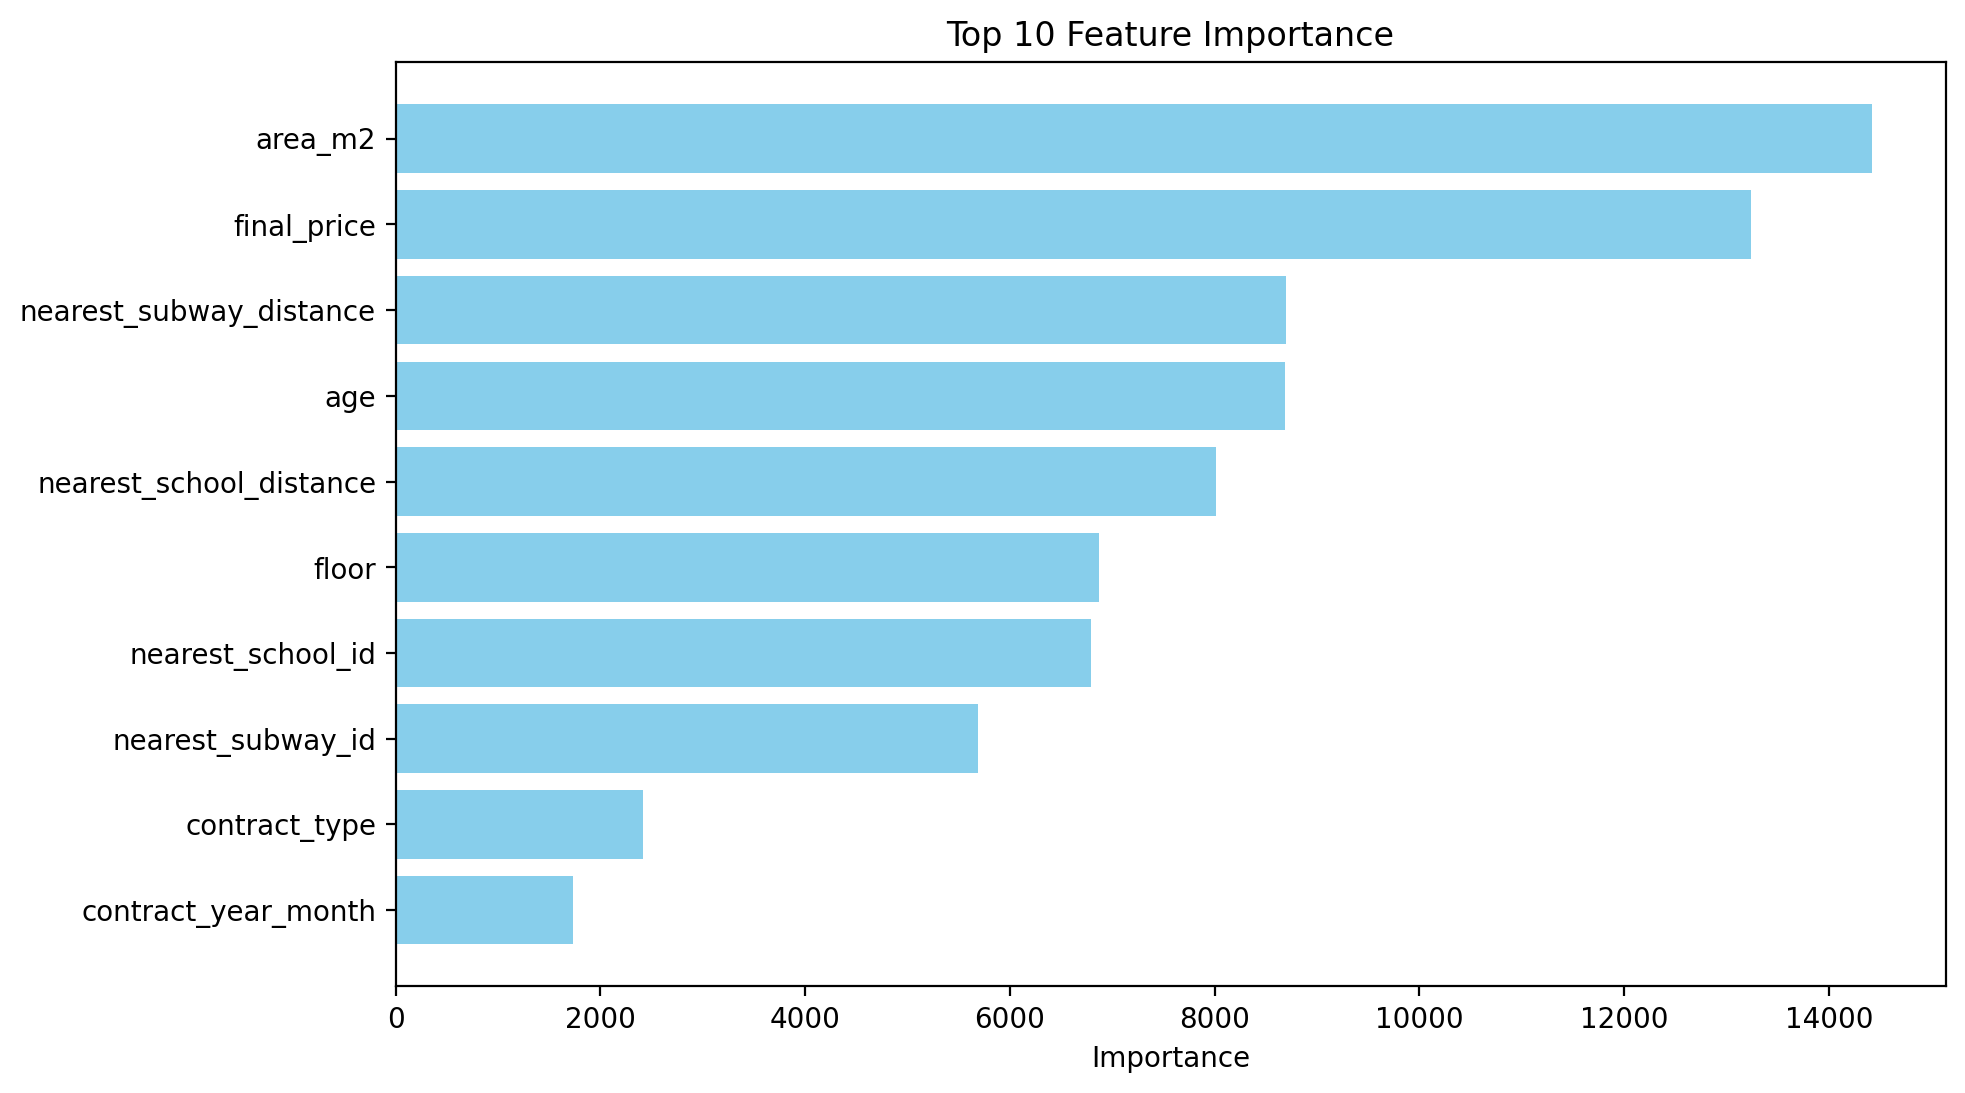

In [28]:
# Feature Importance 추출 및 시각화
feature_importance = lgb_model.feature_importances_

# Feature Importance를 시각화
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)
# 상위 10개의 feature 선택
top_10_features = importance_df.nlargest(10, 'importance')

# 그래프 그리기
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()




# 전체 학습 후 제출

In [29]:
train_data = train_dist[columns_needed]
test_data = test_dist[columns_needed_test]

In [30]:
X_train = train_data.drop(columns=['deposit','deposit_per_area'])
y_train = train_data['deposit_per_area']
X_test = test_data.copy()

In [31]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 57253, number of used features: 109
[LightGBM] [Info] Start training from score 413.510372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 57253, number of used features: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

In [32]:
lgb_test_pred = lgb_model.predict(X_test)
lgb_test_pred_origin = lgb_test_pred*test_data['area_m2']
sample_submission['deposit'] = lgb_test_pred_origin

<Axes: >

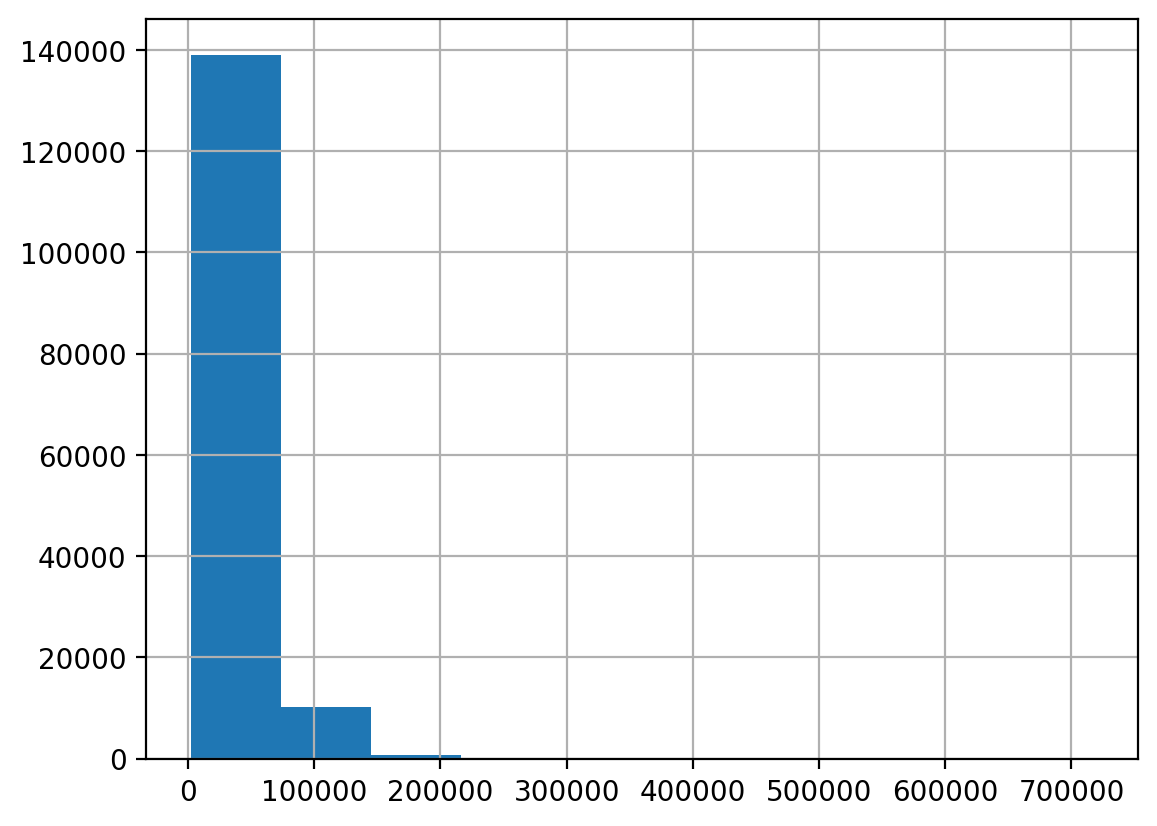

In [33]:
sample_submission['deposit'].hist()

In [34]:
sample_submission['deposit'].describe()

count   150172.00
mean     39157.75
std      24808.56
min       2283.93
25%      22982.66
50%      33363.35
75%      48765.50
max     716832.44
Name: deposit, dtype: float64

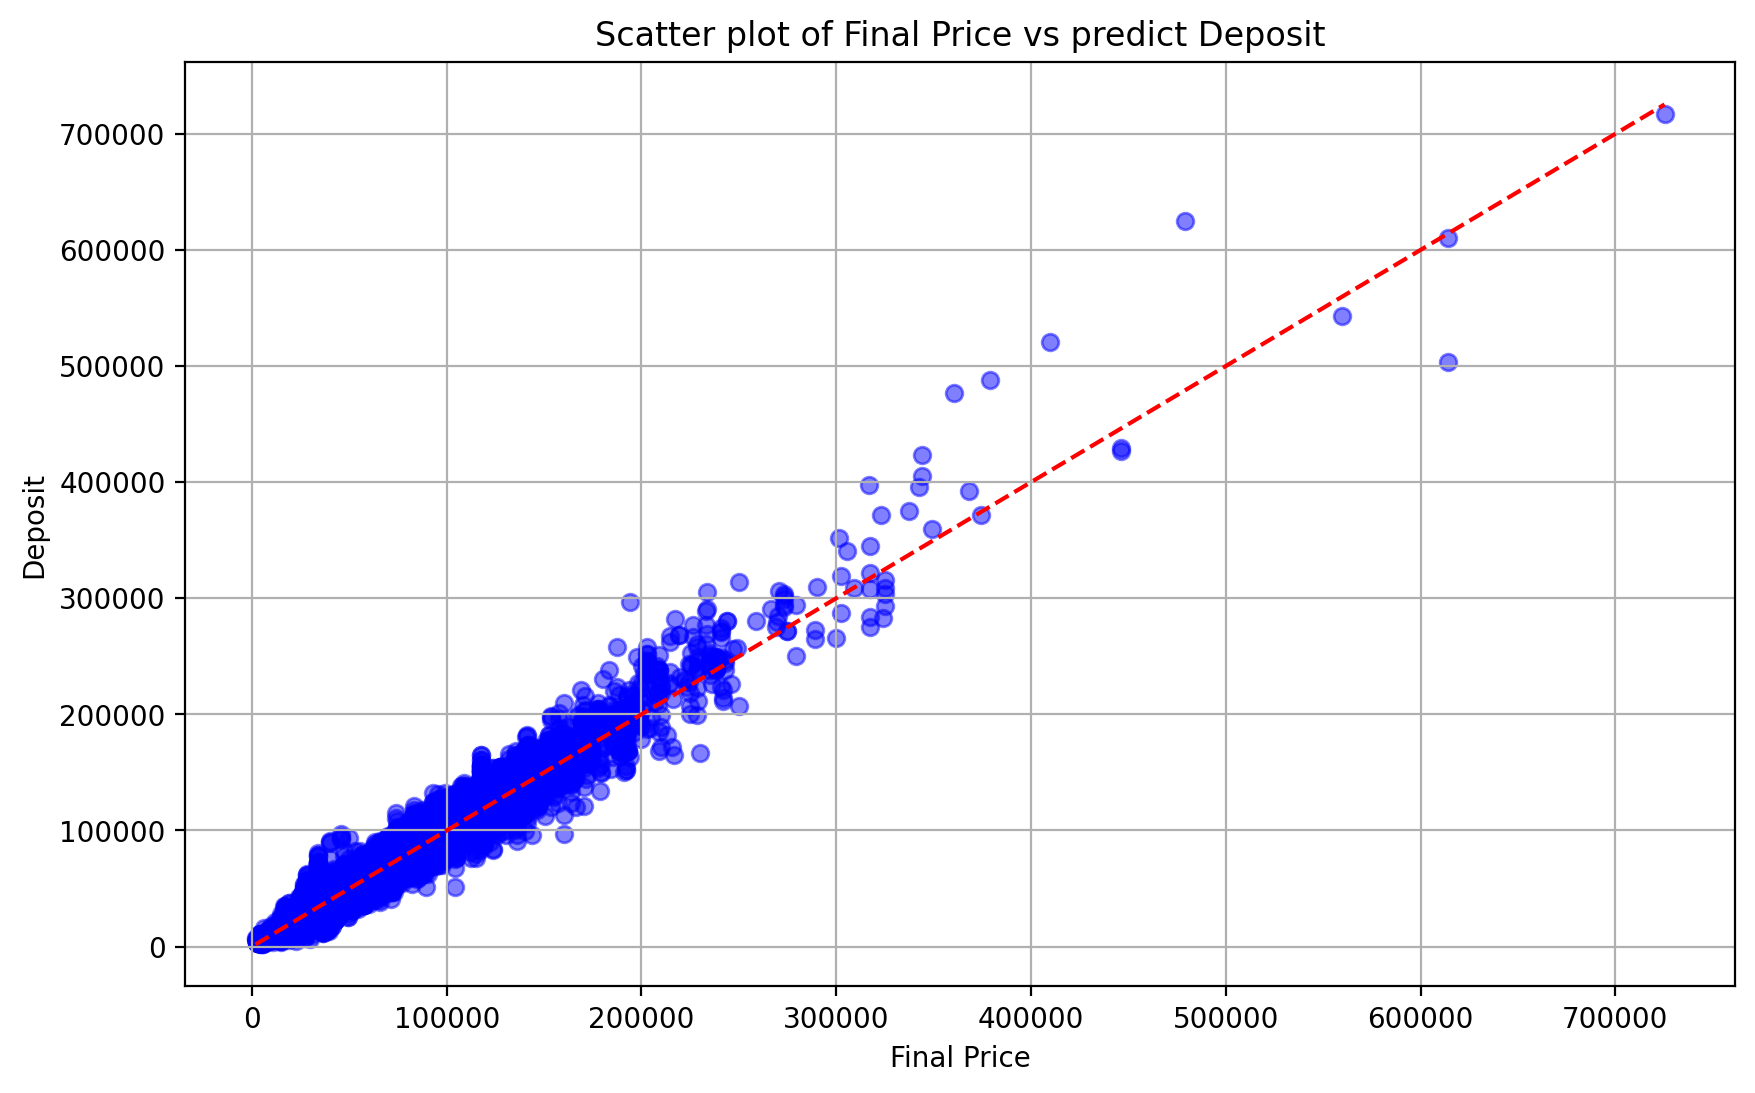

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(test_dist['final_price']*test_dist['area_m2'], sample_submission['deposit'], color='blue', alpha=0.5)

# x=y 선 그리기
min_value = min((test_dist['final_price'] * test_dist['area_m2']).min(), sample_submission['deposit'].min())
max_value = max((test_dist['final_price'] * test_dist['area_m2']).max(), sample_submission['deposit'].max())
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='x=y')

plt.xlabel('Final Price')
plt.ylabel('Deposit')
plt.title('Scatter plot of Final Price vs predict Deposit')
plt.grid(True)
plt.show()

In [36]:
#sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')